In [1]:
import math
import random
import minigrid
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from array2gif import write_gif
from minigrid.wrappers import ImgObsWrapper, FullyObsWrapper


import gym_examples
from models import *
from utils import *

pygame 2.5.2 (SDL 2.28.2, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
num_skills = 8
skill_eps_len = 10  # 90 10
skill_eps_count = 10
num_episodes = 1000  # 600
discount = 0.9
final_step_discount = 0.99
lr_pred = 1e-4
lr_reg = 1e-4
lr_policy = 1e-4
lr_extractor = 1e-4
BATCH_SIZE = 64  # 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 50000
TAU = 0.005
features_dim = 128
memory = ReplayMemory(10000)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


/home/zhaoyutian/Documents/nlp/lib/python3.10/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
# seaquest gpu out of memory
# env = gym.make('gym_examples/GridWorld-v0', size=10, render_mode="rgb_array")
# env = gym.make('gym_examples:gym_examples/GridWorld-v0', size=10, render_mode="rgb_array")
# env = gym_examples.AgentLocation(env)
# env = gym_examples.FullFrame(env)

env = gym.make("MiniGrid-FourRooms-v0", render_mode="rgb_array")
env = FullyObsWrapper(env)
env = ImgObsWrapper(env)

n_actions = env.action_space.n
# obs, info = env.reset()
# print(obs.shape)

/home/zhaoyutian/Documents/nlp/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.width to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.width` for environment variables or `env.get_wrapper_attr('width')` that will search the reminding wrappers.
  logger.warn(
/home/zhaoyutian/Documents/nlp/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.height to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.height` for environment variables or `env.get_wrapper_attr('height')` that will search the reminding wrappers.
  logger.warn(


In [4]:
feature_extractor = FeaturesExtractor(
    env.observation_space, features_dim=features_dim, concat=1
).to(device)

predictor_net = Head(features_dim * 2, num_skills, if_prob=True).to(device)
# regularizer_net = Head(features_dim, num_skills, if_prob=True).to(device)
prev_predictor_net = Head(features_dim * 2, num_skills, if_prob=True).to(
    device
)
# prev_regularizer_net = Head(features_dim, num_skills, if_prob=True).to(device)

policy_net = Head(features_dim + 1, n_actions).to(device)
target_net = Head(features_dim + 1, n_actions).to(device)

prev_predictor_net.load_state_dict(predictor_net.state_dict())
# prev_regularizer_net.load_state_dict(regularizer_net.state_dict())
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(
    [
        {"params": policy_net.parameters(), "lr": lr_policy},
        {"params": predictor_net.parameters(), "lr": lr_pred},
        #  {'params': regularizer_net.parameters(), 'lr': lr_reg},
        {"params": feature_extractor.parameters(), "lr": lr_extractor},
    ],
    amsgrad=True,
)

In [5]:
def select_action(state, skill, steps_done):
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state, skill).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

In [6]:
def compute_td_error():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                            batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([
        feature_extractor(torch.tensor(s, dtype=torch.float32, device=device).unsqueeze(0).permute((0, 3, 1, 2))) 
        for s in batch.next_state if s is not None])
    state_batch = torch.cat([
        feature_extractor(torch.tensor(s, dtype=torch.float32, device=device).unsqueeze(0).permute((0, 3, 1, 2))) 
        for s in batch.state])
    action_batch = torch.cat(batch.action)
    # print(batch.reward)
    reward_batch = torch.cat(batch.reward)
    skill_batch = torch.cat(batch.skill)
    state_action_values = policy_net(
        state_batch, skill_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(
            non_final_next_states, skill_batch[non_final_mask]).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    td_error = criterion(state_action_values,
                         expected_state_action_values.unsqueeze(1))

    # # Optimize the model
    # optimizer.zero_grad()
    # loss.backward()
    # # In-place gradient clipping
    # torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    # optimizer.step()

    return td_error

In [7]:
steps_done = 0
predictor_update_preiod = 10
td_error_list = []
reward_list = []
pred_loss_list = []
reg_loss_list = []

for i_episode in range(num_episodes):
    # Initialize the environment and get it's state
    state, info = env.reset()
    state_feature = feature_extractor(torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(
        0).permute((0, 3, 1, 2)))  # (N, W, H, C) -> (N, D)
    for i_skil_eps in range(skill_eps_count):
        skill = torch.tensor([random.choice([*range(num_skills)])], device=device).unsqueeze(
            0).repeat(((state_feature.size()[0]), 1))  # [1, 1]
        # skill_state_feature = torch.cat((skill, state_feature), dim=1) # (N, D+1)
        terminal_state = None
        secondary_memory = []
        for t in range(skill_eps_len):
            action = select_action(state_feature, skill, steps_done)
            steps_done += 1
            observation, _, terminated, truncated, _ = env.step(
                action.item())  # zero discount? ignore reward
            # reward = nn.functional.softmax(predictor_net()
            done = terminated or truncated

            next_state = observation
            next_state_feature = feature_extractor(torch.tensor(
                observation, dtype=torch.float32, device=device).unsqueeze(0).permute((0, 3, 1, 2)))

            if terminated:
                secondary_memory.append((state, action, None, skill))
                state = next_state
                state_feature = next_state_feature
                break
            elif truncated:
                secondary_memory.append((state, action, next_state, skill))
                state = next_state
                state_feature = next_state_feature
                break
            else:
                secondary_memory.append((state, action, next_state, skill))
                state = next_state
                state_feature = next_state_feature

        initial_state = secondary_memory[0][0]
        initial_state_feature = feature_extractor(torch.tensor(
            state, dtype=torch.float32, device=device).unsqueeze(0).permute((0, 3, 1, 2)))
        init_terminal_feature = torch.cat(
            (initial_state_feature, state_feature), dim=1)
        with torch.no_grad():
            reward = prev_predictor_net(init_terminal_feature)[
                :, skill.item()] # - prev_regularizer_net(state_feature)[:, skill.item()]
            # print(reward)

        for s, a, ns, sk in secondary_memory:
            memory.push(s, a, ns, sk, reward)

        td_error = compute_td_error()

        pred_loss = - \
            torch.log(predictor_net(init_terminal_feature))[:, skill.item()]
        # NOTE: Following paper, cross entropy is not used
        # reg_loss = - torch.log(regularizer_net(state_feature))[:, skill.item()]

        if td_error:
            target_net_state_dict = target_net.state_dict()
            policy_net_state_dict = policy_net.state_dict()
            for key in policy_net_state_dict:
                target_net_state_dict[key] = policy_net_state_dict[key] * \
                    TAU + target_net_state_dict[key]*(1-TAU)
            target_net.load_state_dict(target_net_state_dict)
            # TODO: parallelizable?
            loss = td_error + pred_loss # + reg_loss
            td_error_list.append(td_error)
        else:
            loss = pred_loss # + reg_loss
            td_error_list.append(torch.tensor(0))

        reward_list.append(reward)
        pred_loss_list.append(pred_loss)
        # reg_loss_list.append(reg_loss)

        # Optimize the model
        optimizer.zero_grad()
        loss.backward()
        # In-place gradient clipping
        if td_error:
            torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
        optimizer.step()

        predictor_update_preiod -= 1
        if not predictor_update_preiod:
            prev_predictor_net.load_state_dict(predictor_net.state_dict())
            # prev_regularizer_net.load_state_dict(regularizer_net.state_dict())
            predictor_update_preiod = 10

        if done:
            # TODO: caution of breaking nested loop
            break

    if i_episode > 0 and not i_episode % 100:
        torch.save(target_net.state_dict(), 'target_net_{}.dict'.format(i_episode))
        torch.save(feature_extractor.state_dict(), 'feature_extractor_{}.dict'.format(i_episode))

print('Complete')

TypeError: Transition.__new__() missing 1 required positional argument: 'init_terminal'

In [ ]:
# env = gym.make('gym_examples/GridWorld-v0', size=10, render_mode="rgb_array")
# # env = gym.make('gym_examples:gym_examples/GridWorld-v0', size=10, render_mode="rgb_array")
# env = gym_examples.FullFrame(env)
# env = gym.wrappers.RecordVideo(env, video_folder="eval", name_prefix="eval",
#                                episode_trigger=lambda x: True)
# num_eval_episodes = 1

# for episode_num in range(num_eval_episodes):
#     obs, _ = env.reset()

#     for t in range(100):

#         obs = feature_extractor(torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(
#             0).permute((0, 3, 1, 2)))
#         action = target_net(obs, torch.tensor(
#             [[3]], device=device)).max(1).indices.view(1, 1)
#         print(action)
#         obs, reward, terminated, truncated, _ = env.step(action.item())
#         done = terminated | truncated

#         if done:
#             break

# env.close()

In [ ]:
action_list = []
for i in range(num_skills):
    frames = []
    actions = []
    # env.render()

    for episode in range(1):
        obs, _ = env.reset()

        for t in range(40):
            # env.render()

            frames.append(np.moveaxis(env.get_frame(), 2, 0))
            obs = feature_extractor(torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(0).permute((0, 3, 1, 2)))
            action = target_net(obs, torch.tensor(
                [[i]], device=device)).max(1).indices.view(1, 1)
            actions.append(action)
            obs, reward, terminated, truncated, _ = env.step(action.item())
            done = terminated | truncated

            if done:
                break
    action_list.append(actions)

    write_gif(np.array(frames), f"test{i}.gif", fps=5)

/home/zhaoyutian/Documents/nlp/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_frame to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_frame` for environment variables or `env.get_wrapper_attr('get_frame')` that will search the reminding wrappers.
  logger.warn(


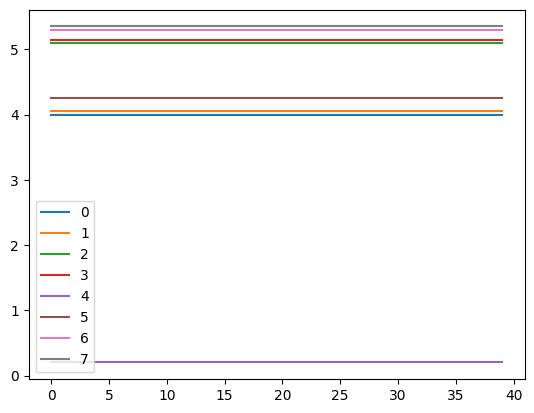

In [ ]:
for ind, lst in enumerate(action_list):
    plt.plot([i.item()+0.05*ind for i in lst], label=ind)
plt.legend()

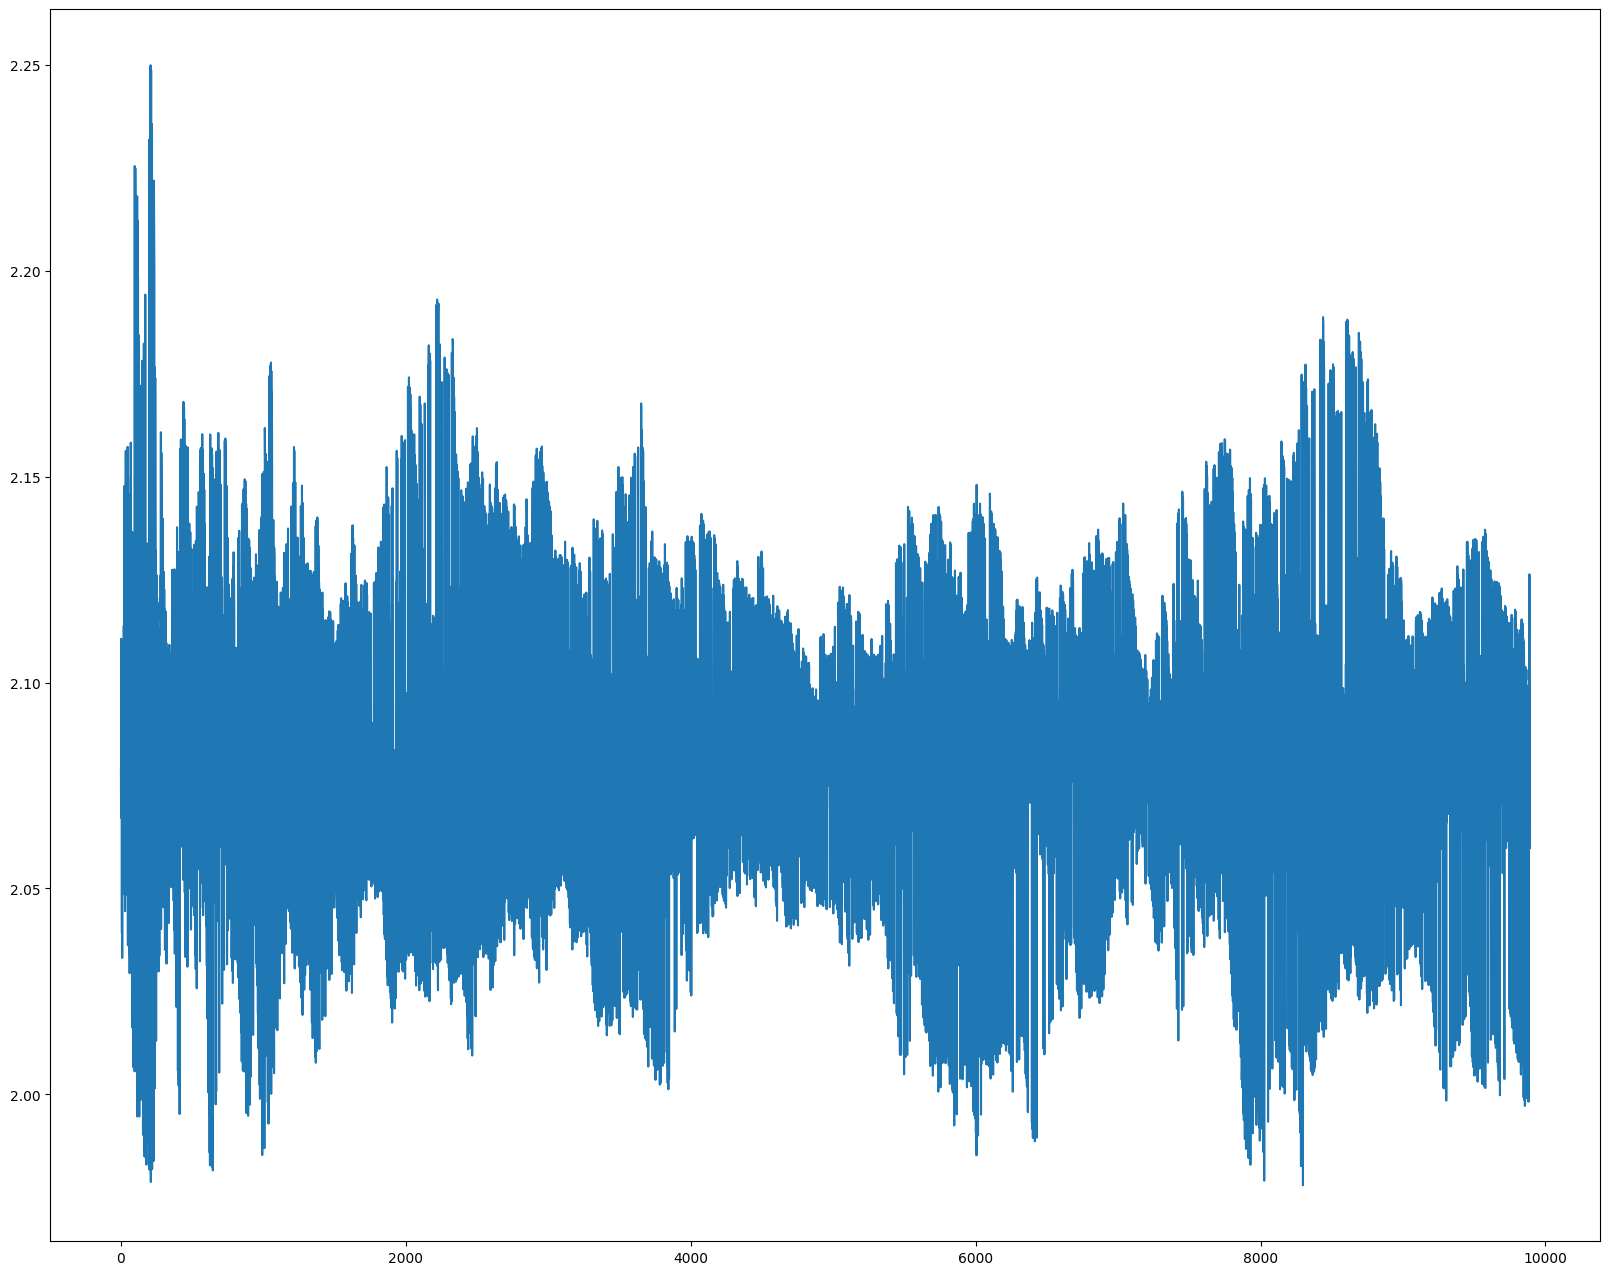

In [ ]:
plt.figure(figsize=(20, 16))
plt.plot([i.item() if type(i) == torch.Tensor else 0 for i in pred_loss_list])
# plt.plot([i.item() if type(i) == torch.Tensor else 0 for i in reg_loss_list])

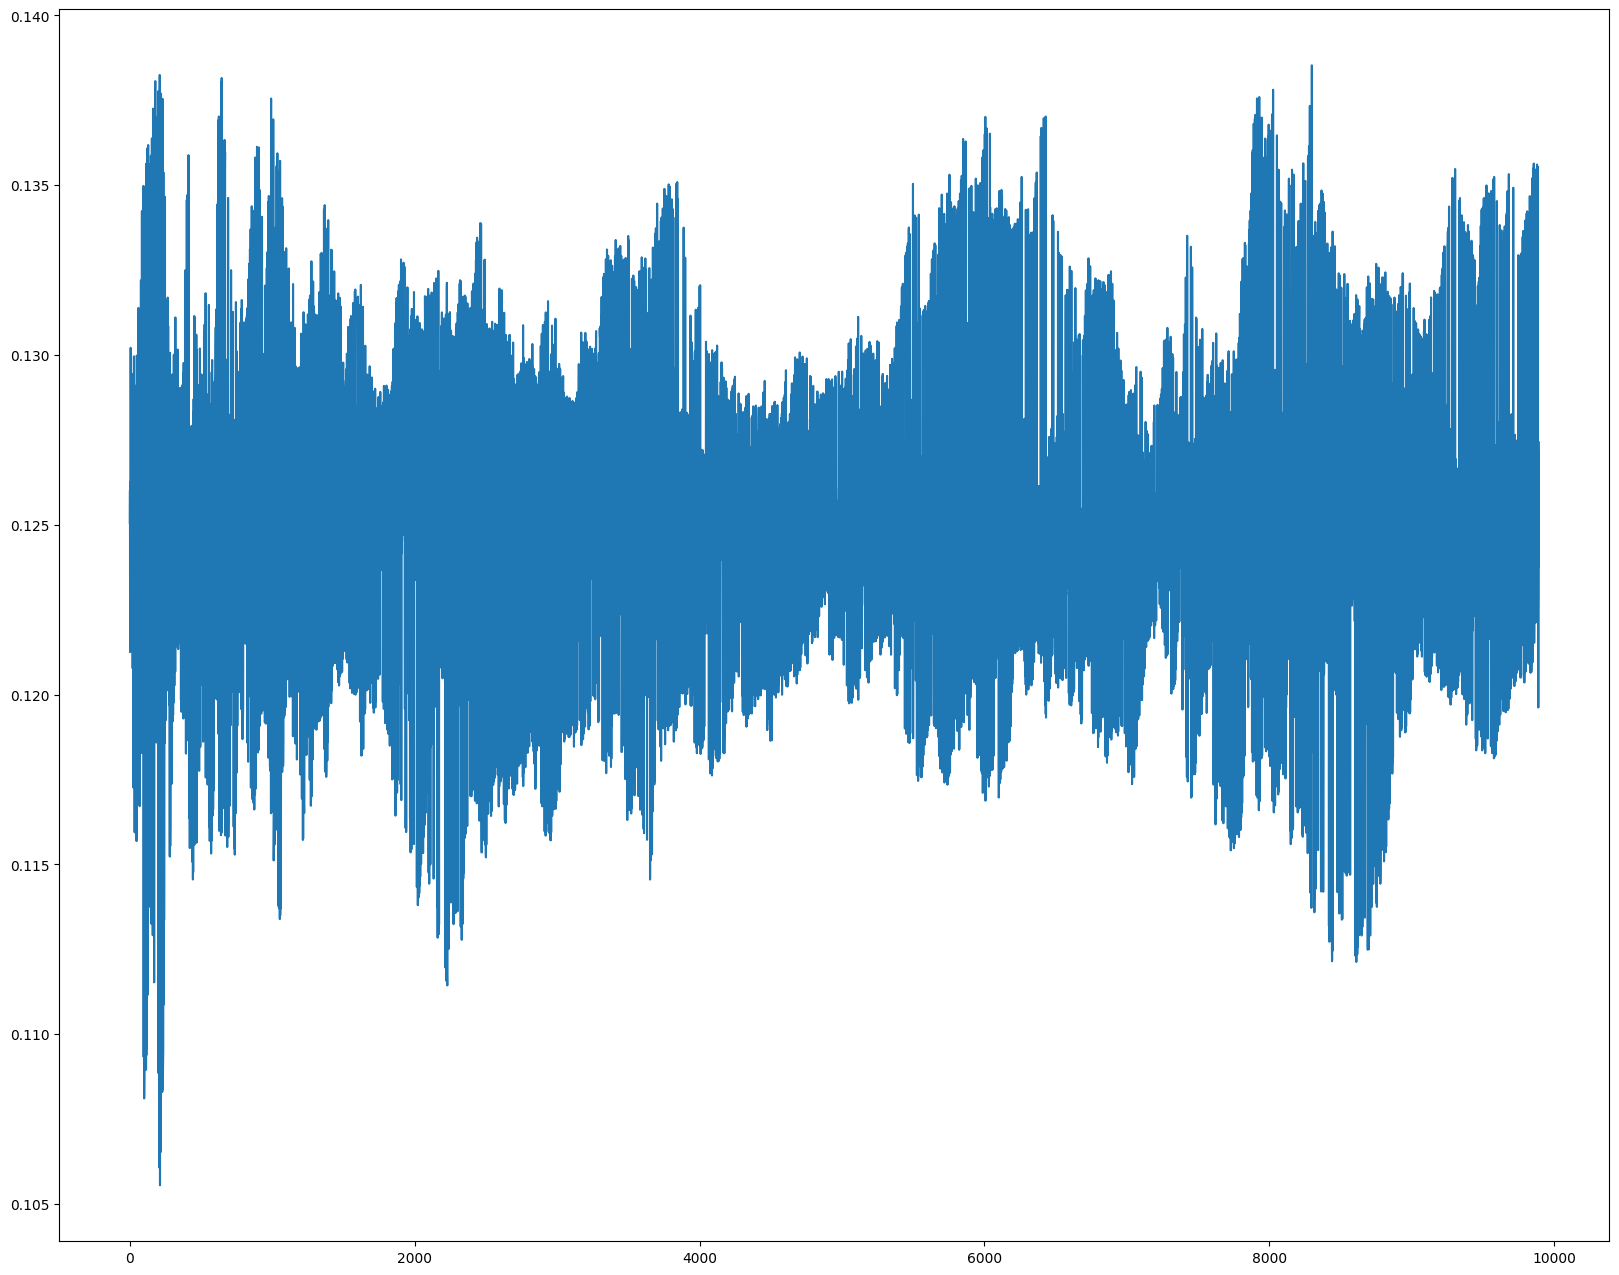

In [ ]:
plt.figure(figsize=(20, 16))
plt.plot([i.item() if type(i) == torch.Tensor else 0 for i in reward_list])

In [ ]:
int(True)

1

In [1]:
import opensimplex

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
import torch

In [4]:
a = torch.Tensor([1,2,3])
b = torch.Tensor([True, False, True])
a*b

tensor([1., 0., 3.])